# Lectura y Análisis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [3]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [4]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

location = "arona"

grafcan = "grafcan_arona"
openmeteo_arpege = "openmeteo_arona_arpege"
openmeteo_icon = "openmeteo_arona_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_arona...
air_temperature           18.041387
atmospheric_pressure    1020.504995
relative_humidity         91.088916
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           18.710947
atmospheric_pressure    1015.166005
relative_humidity         68.337460
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_arona_arpege...
air_temperature           18.0
atmospheric_pressure    1019.7
relative_humidity         87.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.3
atmospheric_pressure    1014.4
relative_humidity         77.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_arona_icon...
air_temperature           18.4
atmospheric_pressure    1019.5
relative_humidity         93.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.1
atmospheric_pressure    1014.4
relative_humidity         89.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [5]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

Plotting air_temperature


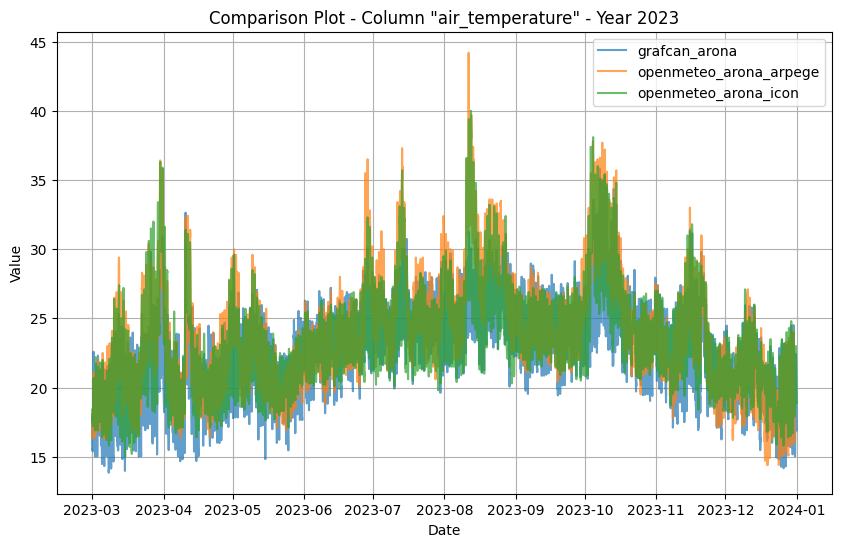

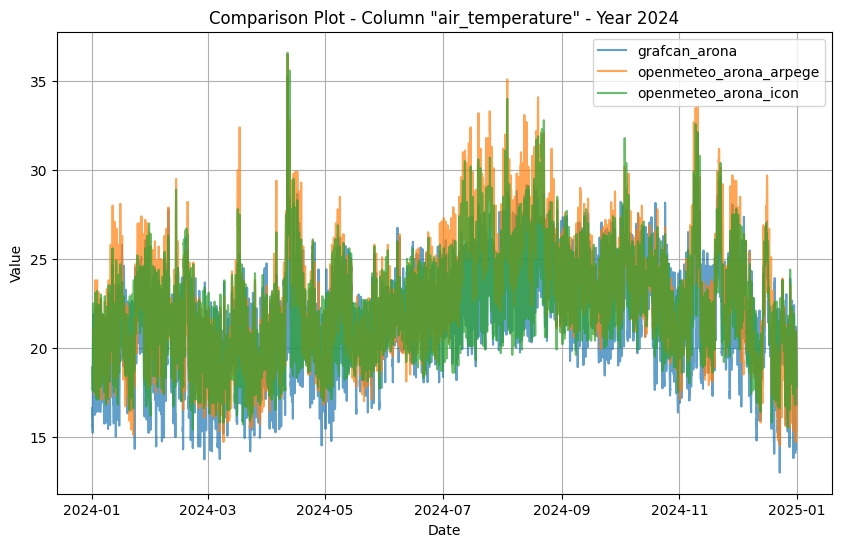

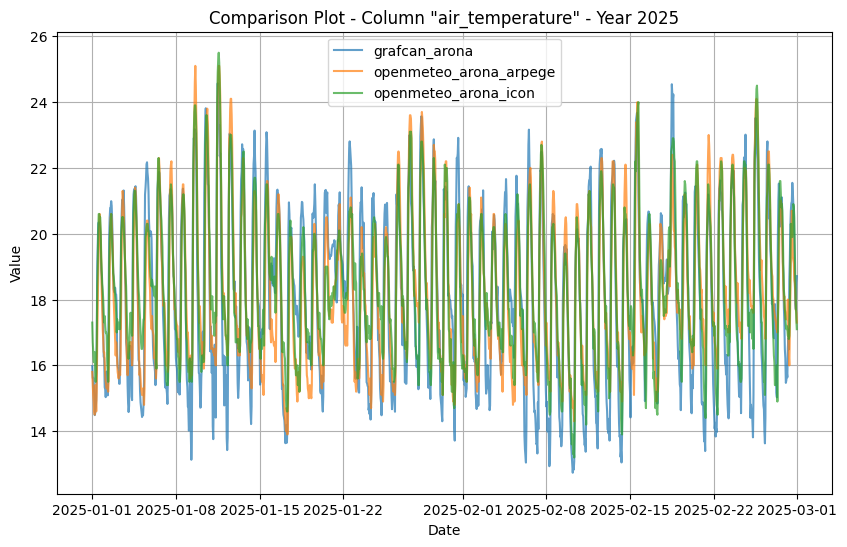

Plotting relative_humidity


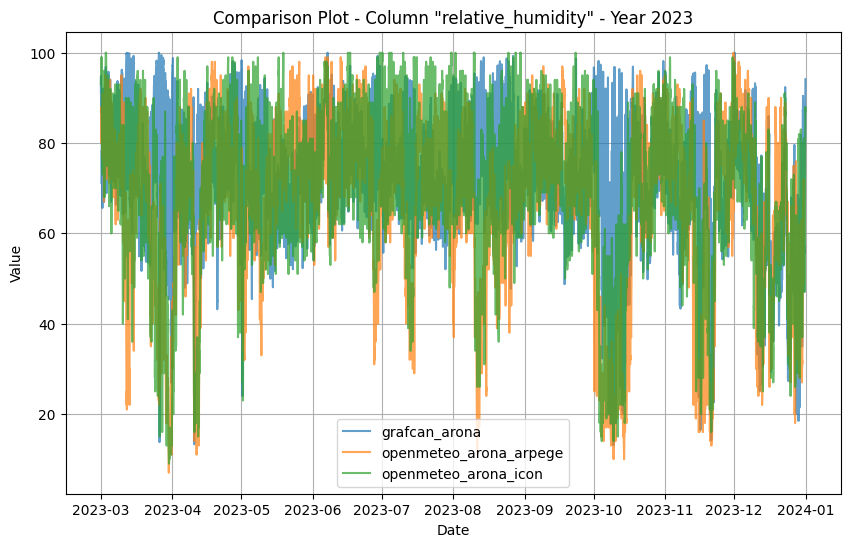

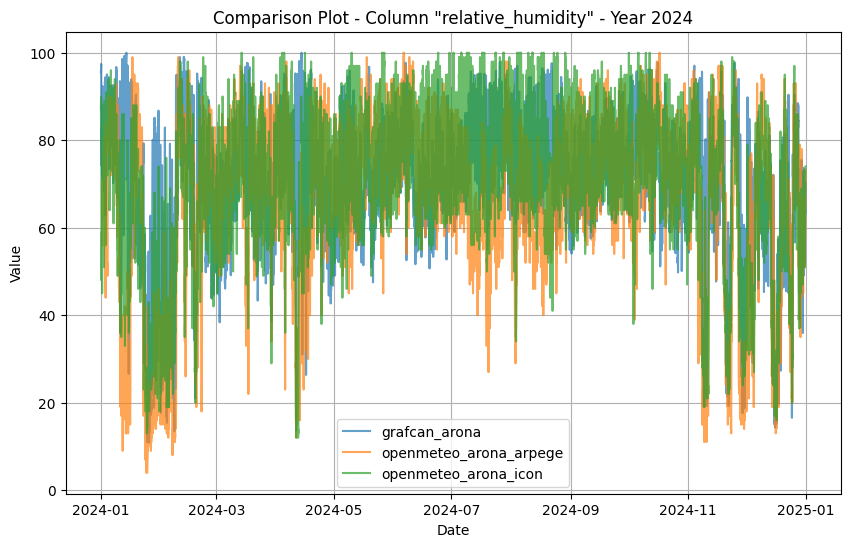

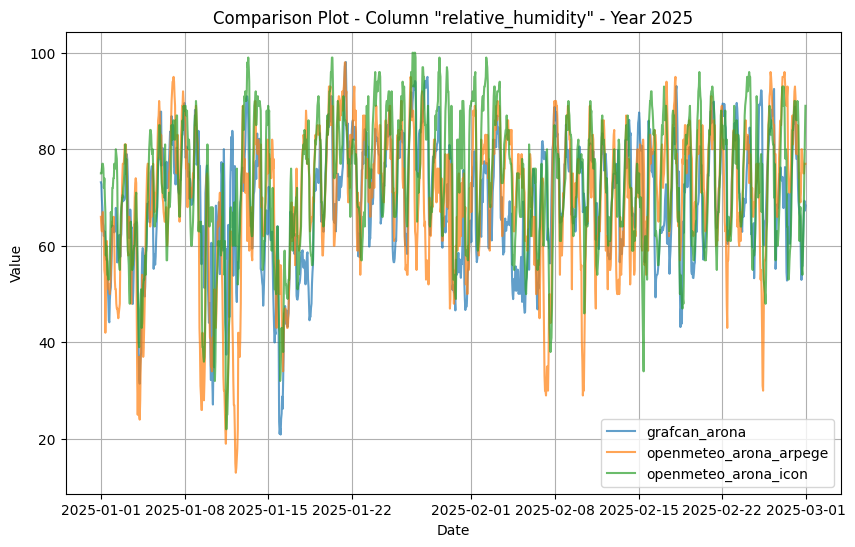

Plotting atmospheric_pressure


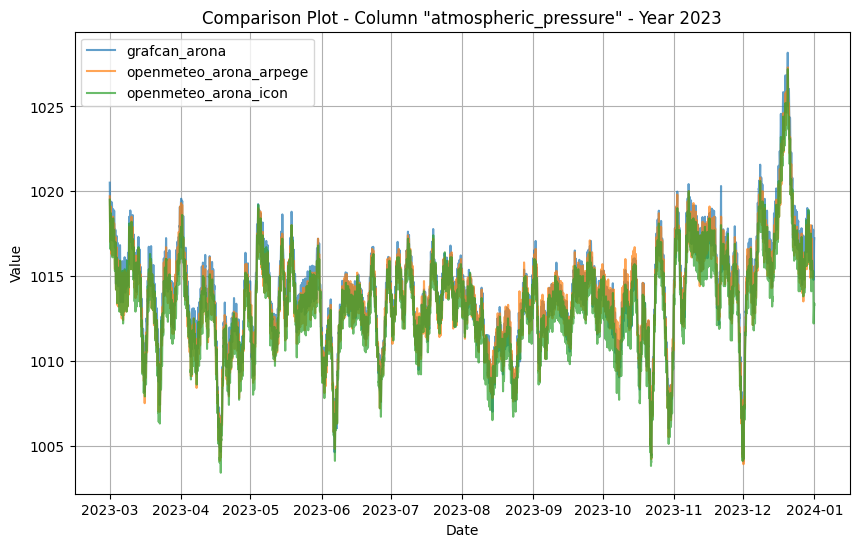

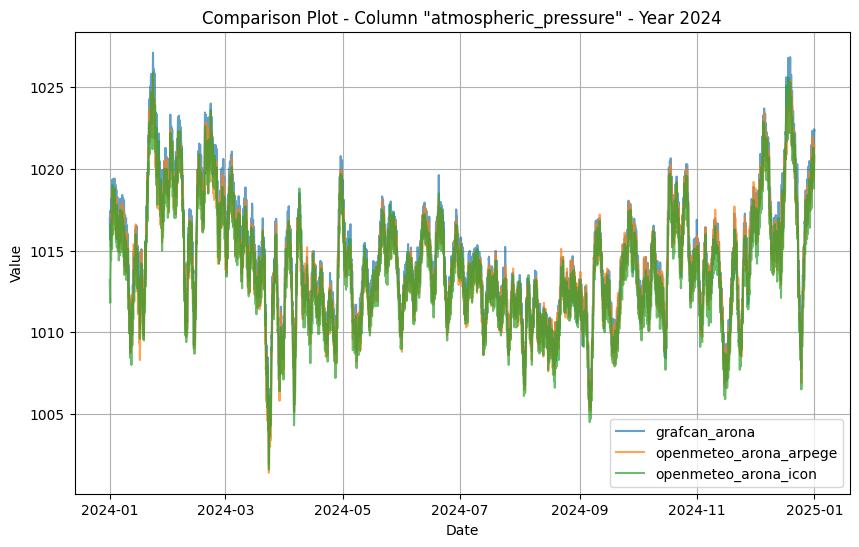

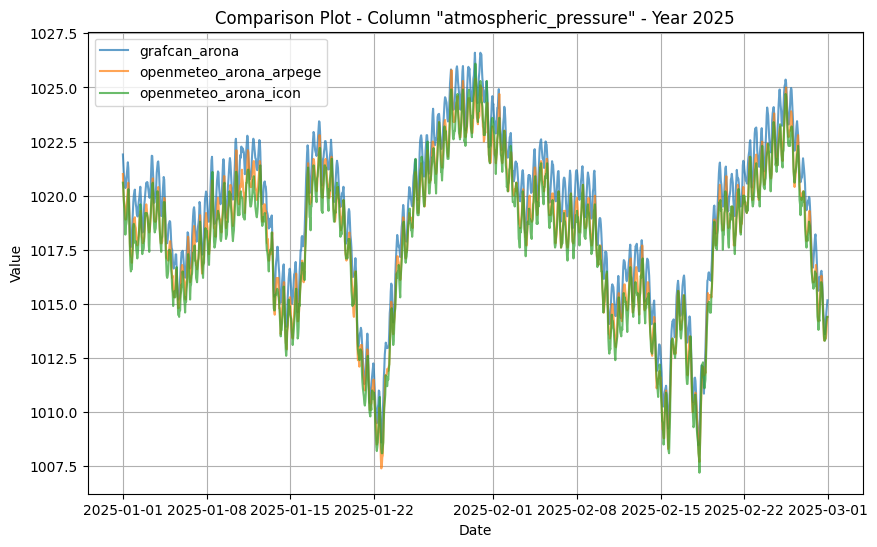

In [6]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [7]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_arona after resampling:
[Timestamp('2023-05-26 01:00:00+0000', tz='UTC'), Timestamp('2023-05-26 02:00:00+0000', tz='UTC'), Timestamp('2023-05-26 03:00:00+0000', tz='UTC'), Timestamp('2023-05-26 11:00:00+0000', tz='UTC'), Timestamp('2023-05-26 12:00:00+0000', tz='UTC'), Timestamp('2023-05-26 13:00:00+0000', tz='UTC'), Timestamp('2023-05-26 15:00:00+0000', tz='UTC'), Timestamp('2023-05-26 16:00:00+0000', tz='UTC'), Timestamp('2023-05-26 17:00:00+0000', tz='UTC'), Timestamp('2023-06-14 01:00:00+0000', tz='UTC'), Timestamp('2023-06-14 02:00:00+0000', tz='UTC'), Timestamp('2023-06-14 03:00:00+0000', tz='UTC'), Timestamp('2023-06-14 04:00:00+0000', tz='UTC'), Timestamp('2023-06-14 05:00:00+0000', tz='UTC'), Timestamp('2023-06-14 06:00:00+0000', tz='UTC'), Timestamp('2023-06-14 07:00:00+0000', tz='UTC'), Timestamp('2023-06-14 08:00:00+0000', tz='UTC')]
17
Missing hours in openmeteo_arona_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timest

### Manejo Horas faltantes

In [8]:
# Use pchip interpolation if gap is small (less or equal to threshold hours) else, use previous day data
def missing_interpolation(df, interpolation_threshold=4):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    # Convert datetime index to numeric for interpolation
    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value_flag column with zeros if not present
    if "artificial_value_flag" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value_flag":
            continue

        series = df[col].copy()
        is_nan = series.isna()
        nan_groups = (is_nan != is_nan.shift()).cumsum()
        nan_runs = is_nan.groupby(nan_groups).sum()
        nan_starts = is_nan.groupby(nan_groups).agg(lambda x: x.index[0])

        # Process each missing block
        for run_length, start_time in zip(nan_runs, nan_starts):
            if run_length == 0:
                continue

            end_time = start_time + pd.Timedelta(hours=run_length - 1)
            time_range = pd.date_range(start_time, end_time, freq="h")

            if run_length > interpolation_threshold:
                # Fill using previous day's same hours
                prev_day_range = time_range - pd.Timedelta(days=1)
                try:
                    fill_values = df.loc[prev_day_range, col].values
                    df.loc[time_range, col] = fill_values
                    df.loc[time_range, "artificial_value_flag"] = 1
                except KeyError:
                    print(f"Previous day data not available to fill gap starting {start_time}")
            else:
                # Will interpolate these later
                continue

        # Interpolate remaining missing values (<= 5 hours)
        remaining_nan = df[col].isna()
        valid_mask = ~remaining_nan

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)
            df.loc[remaining_nan, col] = interpolated_values[remaining_nan]
            df.loc[remaining_nan, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

In [9]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    missing_interpolation(df_hourly)

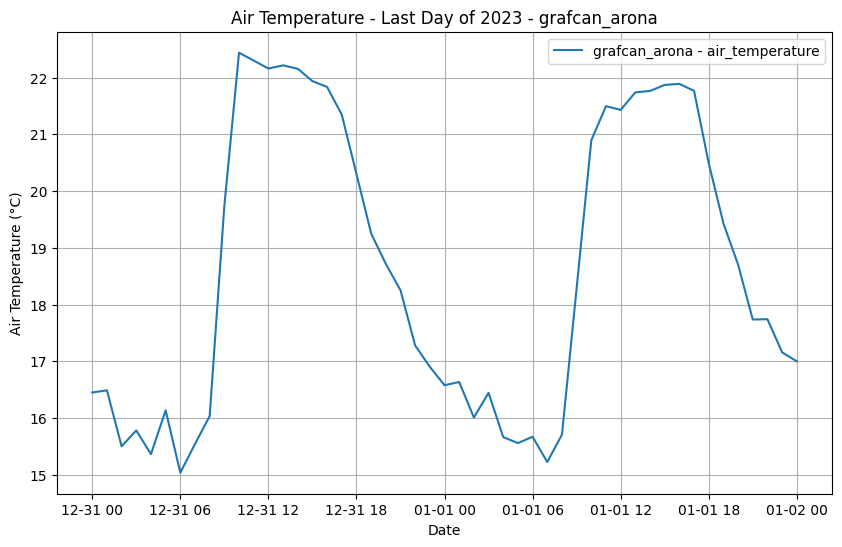

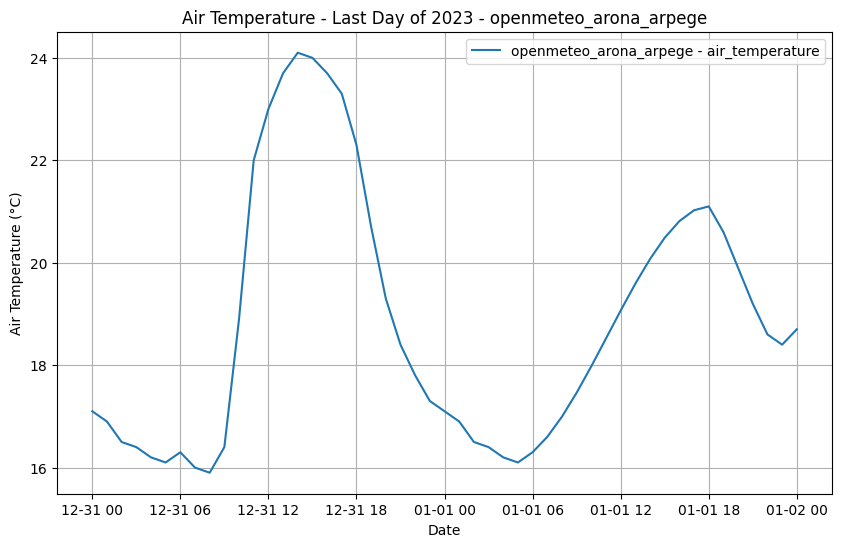

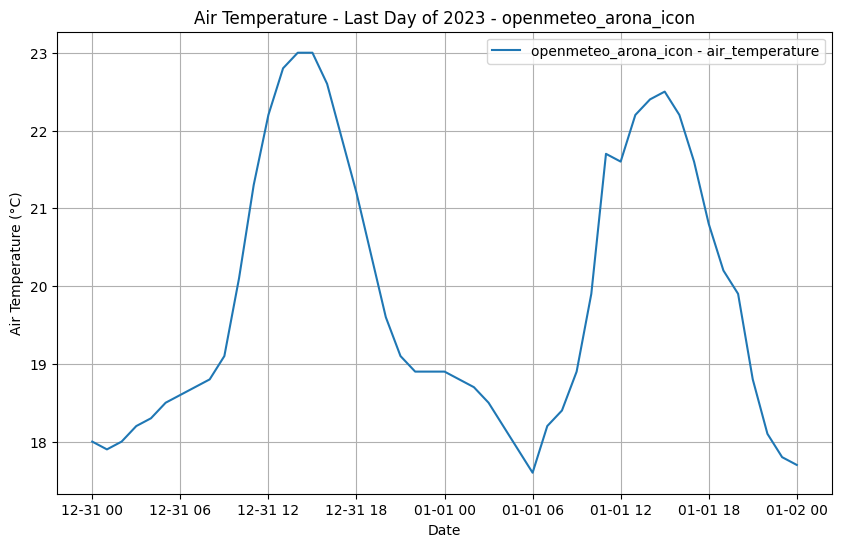

In [10]:
## Plot last day of 2023 and firt day of 2024
days = pd.date_range(start="2023-12-31", end="2024-01-02", freq='h', tz='UTC')
## index is RangeIndex (Timestamp('2023-05-26 01:00:00+0000', tz='UTC'))
for file_key, df_hourly in dataframes.items():
    ## Must get indices of the desired dates
    last_day_indices = df_hourly.index[df_hourly.index.isin(days)]
    plt.figure(figsize=(10, 6))
    plt.plot(last_day_indices, df_hourly.loc[last_day_indices, "air_temperature"], label=f"{file_key} - air_temperature")
    plt.title(f'Air Temperature - Last Day of 2023 - {file_key}')
    plt.xlabel('Date')
    plt.ylabel('Air Temperature (°C)')
    plt.legend()
    plt.grid(True)

## Comparativa datasets openmeteo

In [11]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [12]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_arona_icon vs grafcan_arona
  air_temperature:
    Pearson: 0.8871
    Spearman: 0.9116
    Kendall: 0.7489
    MSE: 2.8616
    Euclidean Distance: 224.0627
  atmospheric_pressure:
    Pearson: 0.9890
    Spearman: 0.9859
    Kendall: 0.9048
    MSE: 1.1085
    Euclidean Distance: 139.4523
  relative_humidity:
    Pearson: 0.6281
    Spearman: 0.6026
    Kendall: 0.4423
    MSE: 208.6453
    Euclidean Distance: 1913.2363


In [13]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_arona_arpege vs grafcan_arona
  air_temperature:
    Pearson: 0.8415
    Spearman: 0.8519
    Kendall: 0.6650
    MSE: 5.6179
    Euclidean Distance: 313.9447
  atmospheric_pressure:
    Pearson: 0.9891
    Spearman: 0.9866
    Kendall: 0.9070
    MSE: 0.5754
    Euclidean Distance: 100.4768
  relative_humidity:
    Pearson: 0.3838
    Spearman: 0.2748
    Kendall: 0.1973
    MSE: 406.1746
    Euclidean Distance: 2669.4431


### Selección de datasets

In [14]:
new_df_openmeteo = "openmeteo_" + location
dataframes[new_df_openmeteo] = dataframes[openmeteo_icon].copy()
dataframes[new_df_openmeteo]["atmospheric_pressure"] = dataframes[openmeteo_arpege]["atmospheric_pressure"].copy()
dataframes[new_df_openmeteo]["artificial_value_flag"] += dataframes[openmeteo_arpege]["artificial_value_flag"]

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [15]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_arona:


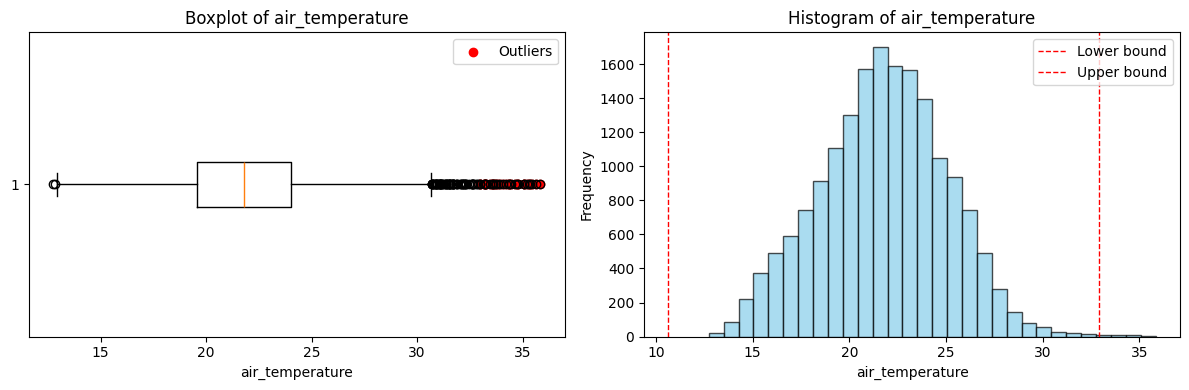

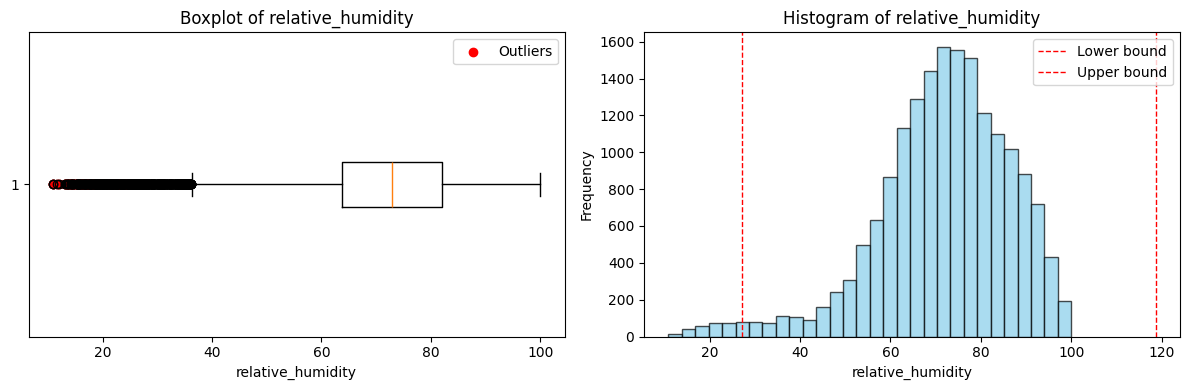

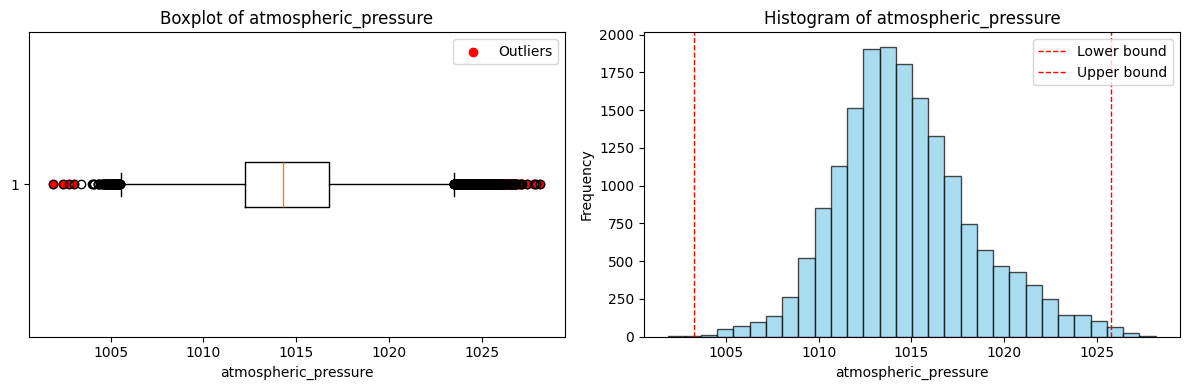

  air_temperature outlier row indices: [Timestamp('2023-10-04 15:00:00+0000', tz='UTC'), Timestamp('2023-10-04 16:00:00+0000', tz='UTC'), Timestamp('2023-10-07 11:00:00+0000', tz='UTC'), Timestamp('2023-10-07 12:00:00+0000', tz='UTC'), Timestamp('2023-10-07 13:00:00+0000', tz='UTC'), Timestamp('2023-10-07 14:00:00+0000', tz='UTC'), Timestamp('2023-10-08 09:00:00+0000', tz='UTC'), Timestamp('2023-10-08 10:00:00+0000', tz='UTC'), Timestamp('2023-10-08 11:00:00+0000', tz='UTC'), Timestamp('2023-10-09 10:00:00+0000', tz='UTC'), Timestamp('2023-10-09 11:00:00+0000', tz='UTC'), Timestamp('2023-10-09 12:00:00+0000', tz='UTC'), Timestamp('2023-10-09 13:00:00+0000', tz='UTC'), Timestamp('2023-10-09 14:00:00+0000', tz='UTC'), Timestamp('2023-10-09 15:00:00+0000', tz='UTC'), Timestamp('2023-10-09 16:00:00+0000', tz='UTC'), Timestamp('2023-10-09 17:00:00+0000', tz='UTC'), Timestamp('2023-10-10 11:00:00+0000', tz='UTC'), Timestamp('2023-10-10 12:00:00+0000', tz='UTC'), Timestamp('2023-10-10 13:00:0

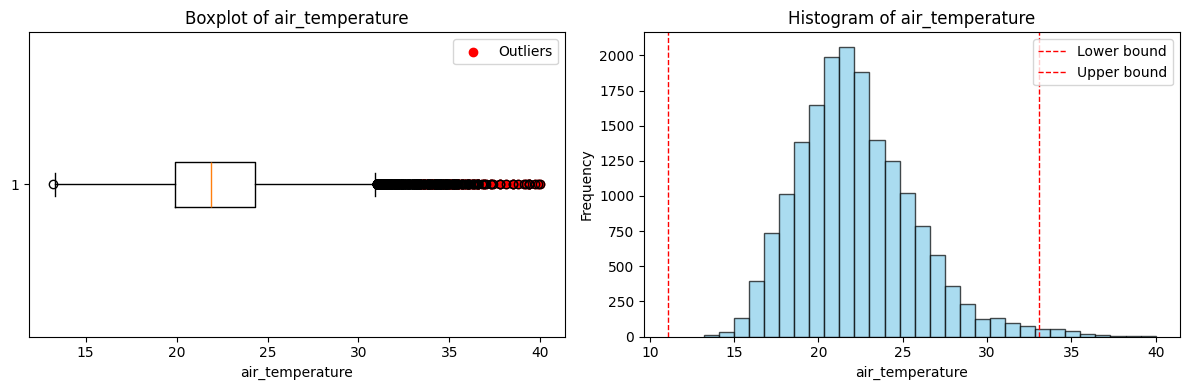

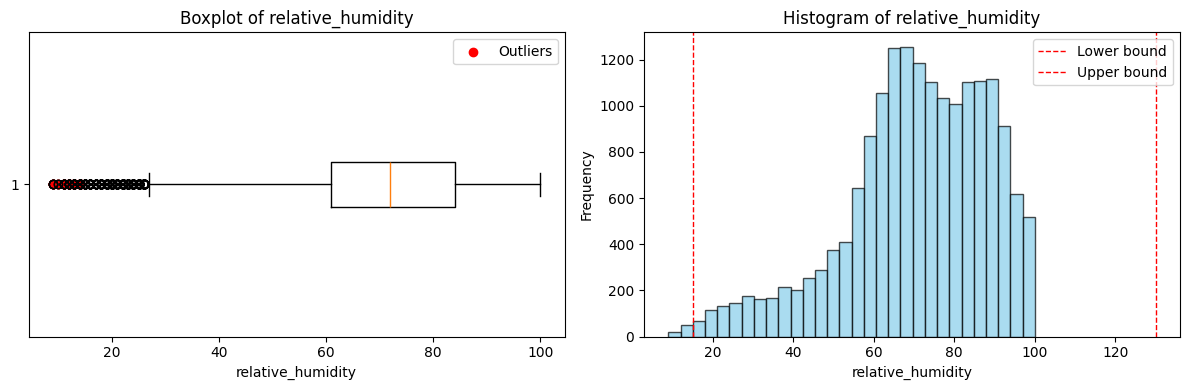

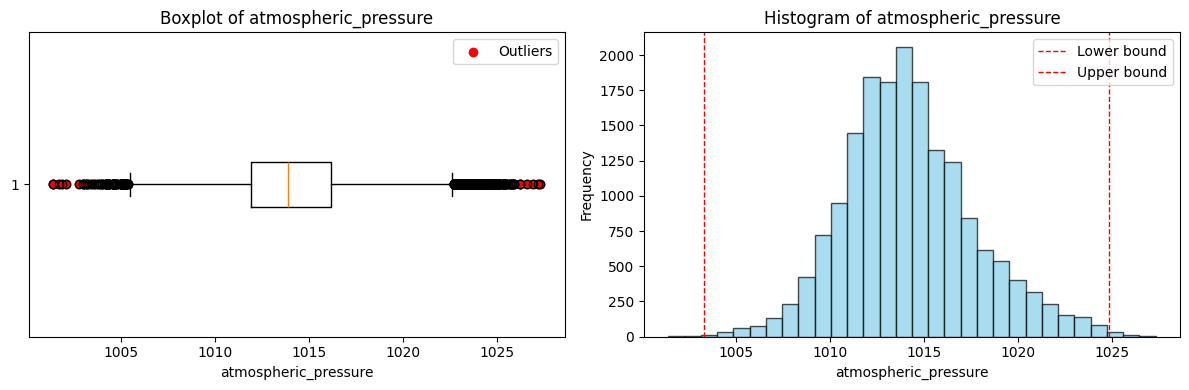

  air_temperature outlier row indices: [Timestamp('2023-03-29 13:00:00+0000', tz='UTC'), Timestamp('2023-03-29 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 10:00:00+0000', tz='UTC'), Timestamp('2023-03-30 11:00:00+0000', tz='UTC'), Timestamp('2023-03-30 12:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-30 17:00:00+0000', tz='UTC'), Timestamp('2023-03-30 18:00:00+0000', tz='UTC'), Timestamp('2023-03-31 09:00:00+0000', tz='UTC'), Timestamp('2023-03-31 10:00:00+0000', tz='UTC'), Timestamp('2023-03-31 11:00:00+0000', tz='UTC'), Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-03-31 17:00:0

In [16]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

In [45]:
def plot_threshold_vs_outliers(mean_distances, multipliers=None):
    """
    Plot number of outliers detected vs threshold multiplier.

    Parameters:
    - mean_distances: array of mean distances per sample.
    - multipliers: list/array of std deviation multipliers to try (e.g. [0, 1, 2, 3, 4, 5]).
      If None, defaults to np.linspace(0, 6, 50)
    """
    mean_val = mean_distances.mean()
    std_val = mean_distances.std()

    if multipliers is None:
        multipliers = np.linspace(0, 6, 50)

    outlier_counts = []
    for m in multipliers:
        threshold = mean_val + m * std_val
        count = np.sum(mean_distances > threshold)
        outlier_counts.append(count)

    plt.figure(figsize=(8, 5))
    plt.plot(multipliers, outlier_counts, marker='o')
    plt.xlabel("Threshold multiplier (times std deviation)")
    plt.ylabel("Number of outliers detected")
    plt.title("Number of outliers detected vs threshold multiplier")
    plt.grid(True)
    plt.show()


Processing grafcan_arona for KNN outlier detection...
Plotting elbow for air_temperature
Running KNN outlier detection on air_temperature


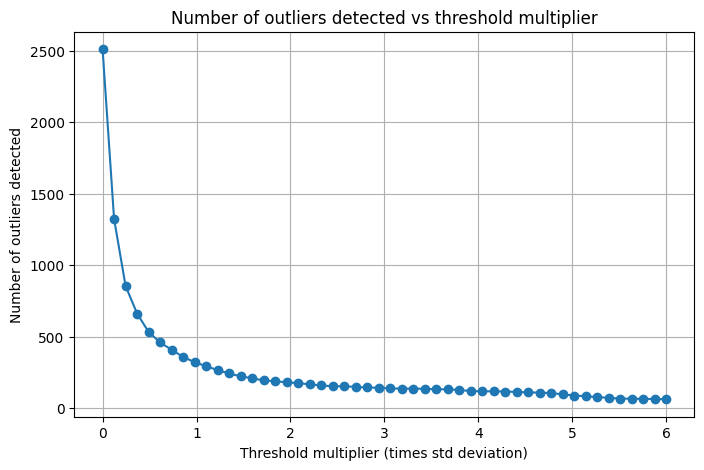

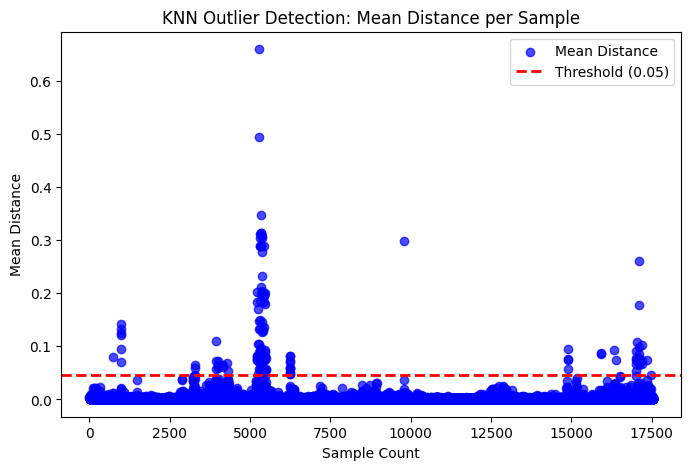

Detected 141 outliers at indices: [  732   971   972   973   974   975   977  3278  3279  3281  3925  3926
  3927  3996  3997  3998  3999  4142  4143  4272  4311  5219  5220  5221
  5222  5223  5224  5225  5246  5247  5248  5249  5266  5267  5270  5271
  5272  5273  5290  5291  5292  5293  5294  5295  5296  5297  5311  5312
  5313  5314  5315  5316  5317  5318  5319  5320  5321  5337  5338  5339
  5340  5341  5342  5343  5344  5345  5346  5362  5363  5364  5365  5366
  5367  5368  5369  5370  5410  5411  5412  5413  5414  5434  5435  5436
  5437  5438  5439  5440  5441  5442  5458  5459  5460  5461  5462  5463
  5464  5486  5487  5488  6230  6231  6232  6233  6250  6251  6252  6253
  6254  6255  9778 14893 14894 14895 14896 15915 15916 16327 16399 16997
 16998 16999 17020 17022 17046 17047 17070 17090 17091 17092 17093 17094
 17095 17096 17117 17119 17143 17189 17190 17191 17359]
Plotting elbow for atmospheric_pressure
Running KNN outlier detection on atmospheric_pressure


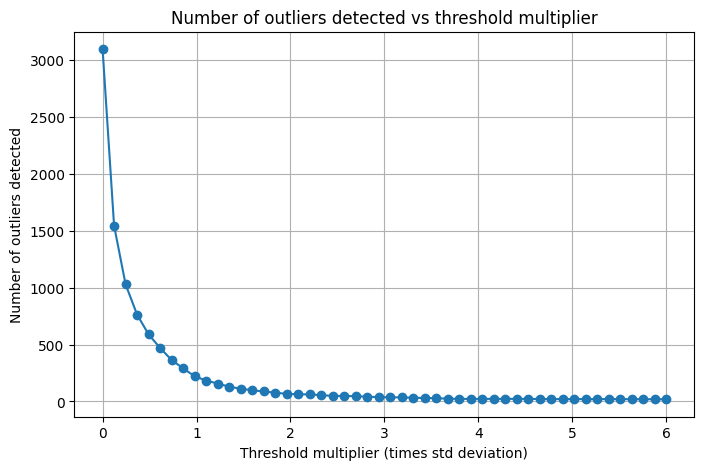

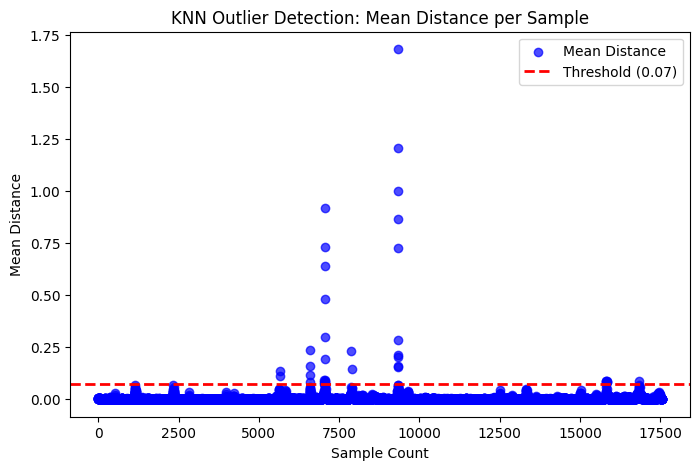

Detected 37 outliers at indices: [ 5643  5644  6592  6593  6603  6604  7041  7042  7053  7057  7059  7061
  7063  7064  7065  7066  7067  7068  7883  7884  9325  9326  9327  9328
  9329  9330  9331  9340  9341  9343 15801 15803 15815 15825 15826 15827
 16845]
Plotting elbow for relative_humidity
Running KNN outlier detection on relative_humidity


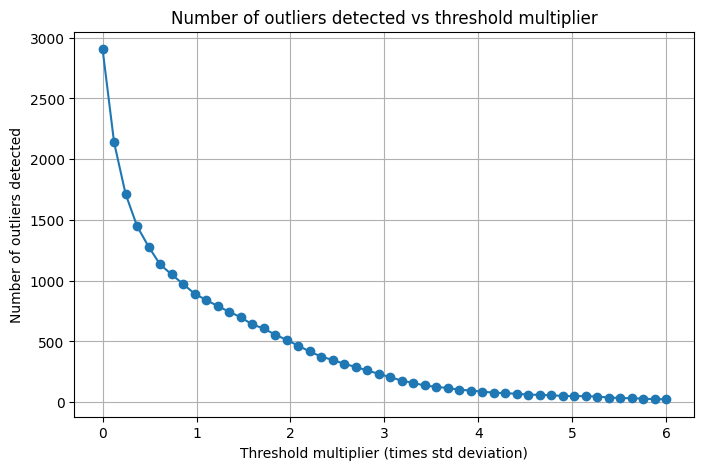

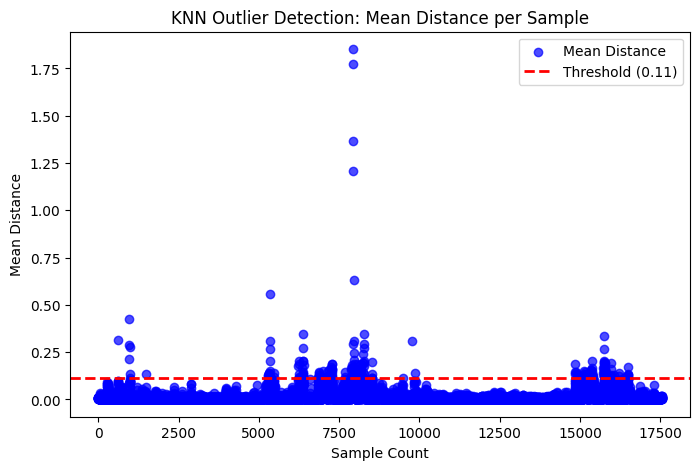

Detected 223 outliers at indices: [  611   971   972   973   974   979   981  1475  5293  5296  5311  5313
  5321  5338  5339  5341  5342  5343  5344  5366  5456  5463  6231  6250
  6252  6253  6254  6255  6350  6352  6359  6361  6362  6363  6365  6366
  6368  6373  6387  6389  6390  6843  6852  6862  6869  6874  6985  7000
  7002  7160  7162  7164  7167  7179  7186  7190  7241  7253  7263  7265
  7268  7269  7271  7272  7277  7280  7282  7690  7691  7879  7881  7883
  7901  7912  7913  7914  7918  7920  7921  7922  7923  7925  7926  7927
  7929  7942  7943  7944  7945  7946  7947  7948  7953  7968  7970  7971
  7972  7973  7974  7976  8005  8031  8043  8051  8089  8090  8093  8095
  8096  8116  8118  8122  8138  8147  8162  8166  8169  8170  8173  8185
  8190  8191  8242  8255  8256  8257  8258  8259  8260  8261  8270  8271
  8272  8521  8522  8523  8526  9471  9778  9855 14847 14849 14855 14859
 14894 14895 15126 15135 15142 15143 15146 15149 15151 15155 15169 15172
 15180 15322 1532

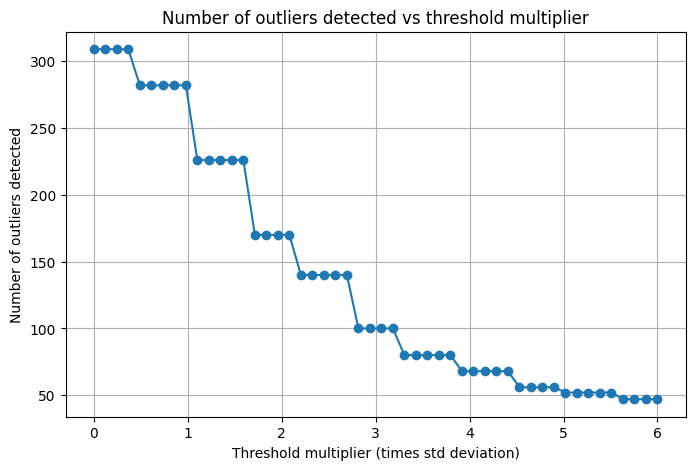

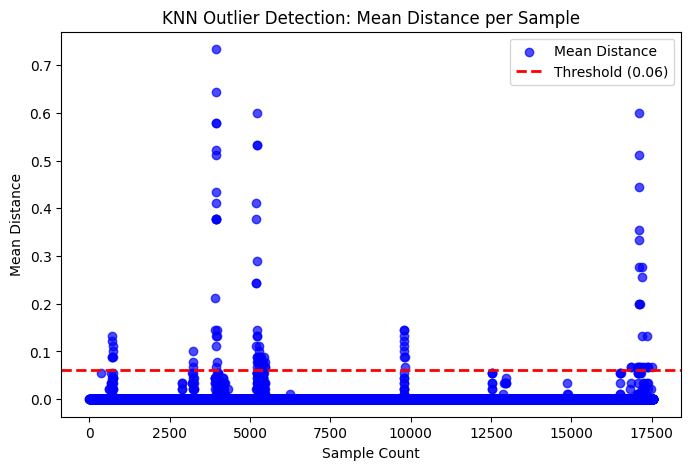

Detected 100 outliers at indices: [  709   710   711   712   731   732   733  3230  3231  3233  3903  3922
  3923  3924  3925  3926  3927  3928  3929  3946  3947  3948  3949  3950
  3951  3952  3953  3971  3973  3974  5195  5196  5197  5198  5199  5200
  5214  5218  5219  5220  5221  5222  5223  5224  5225  5226  5245  5248
  5266  5268  5269  5270  5271  5291  5294  5295  5297  5343  5344  5346
  5364  5386  5438  5459  5464  5465  9779  9780  9781  9782  9783  9784
  9805  9806  9807 16854 16856 17047 17069 17090 17091 17092 17093 17094
 17095 17096 17097 17117 17120 17143 17190 17191 17192 17193 17263 17359
 17360 17382 17384 17504]
Plotting elbow for atmospheric_pressure
Running KNN outlier detection on atmospheric_pressure


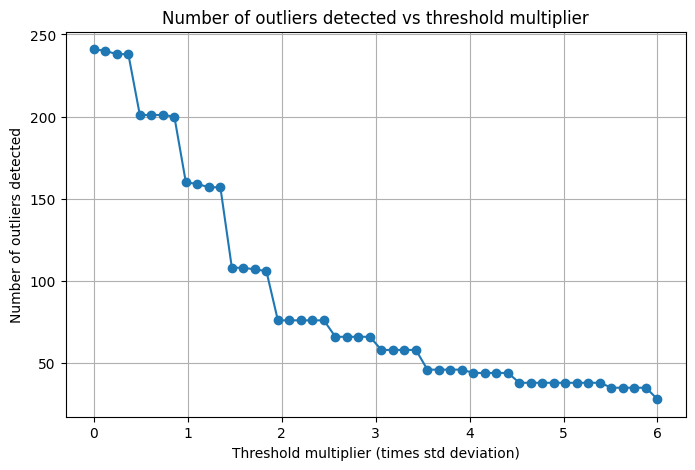

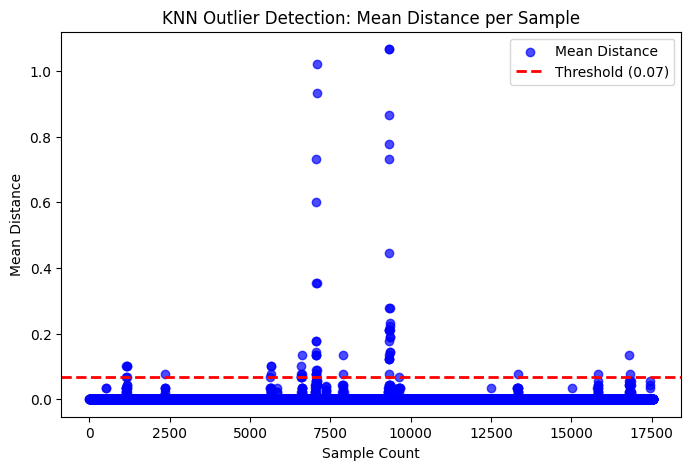

Detected 58 outliers at indices: [ 1147  1156  1157  2346  5640  5641  5645  6596  6598  6600  6605  7043
  7044  7053  7054  7055  7056  7058  7059  7060  7063  7064  7065  7066
  7067  7068  7069  7077  7883  7884  9318  9319  9320  9321  9322  9323
  9324  9325  9326  9327  9328  9329  9330  9331  9332  9338  9340  9341
  9342  9343  9344  9351  9352  9353 13324 15827 16788 16811]
Plotting elbow for relative_humidity
Running KNN outlier detection on relative_humidity


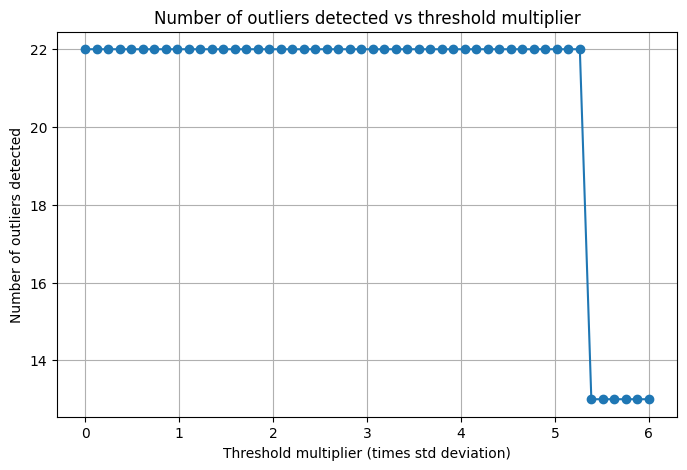

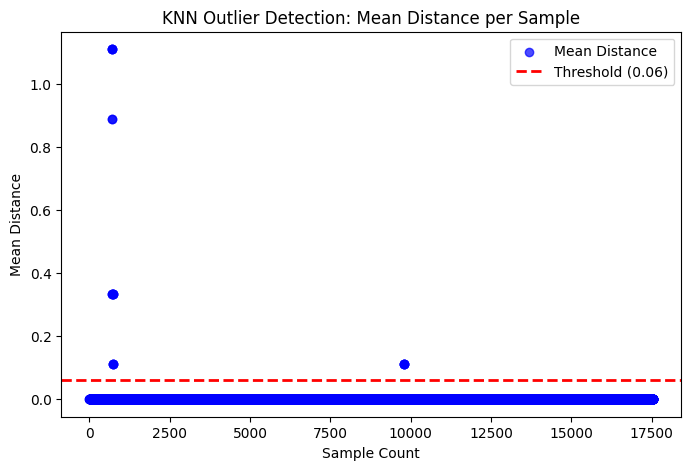

Detected 22 outliers at indices: [ 706  707  708  709  710  711  712  713  714  726  727  728  729  730
  731  732  733 9778 9779 9780 9781 9803]


In [54]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    plot_threshold_vs_outliers(mean_distances)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    for column in ["air_temperature", "atmospheric_pressure", "relative_humidity"]:
        print(f"Plotting elbow for {column}")
        data = df[column].values

        print(f"Running KNN outlier detection on {column}")
        outliers = knn_outlier_detection(data, k=10, threshold=3)  # Adjust `k` after inspecting elbow
        flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_arona...


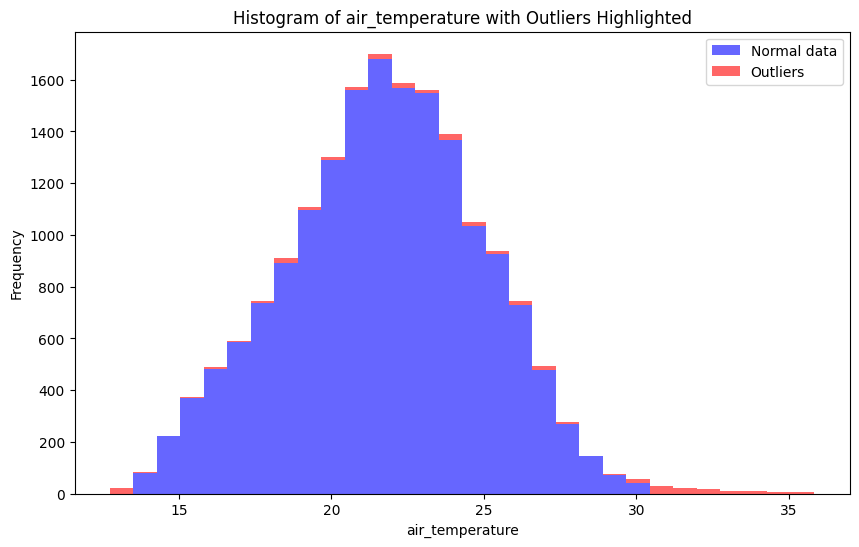

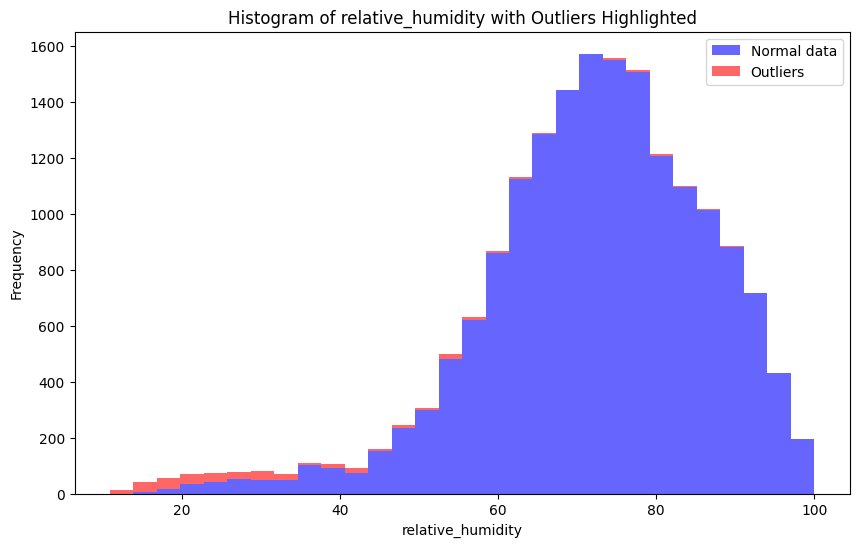

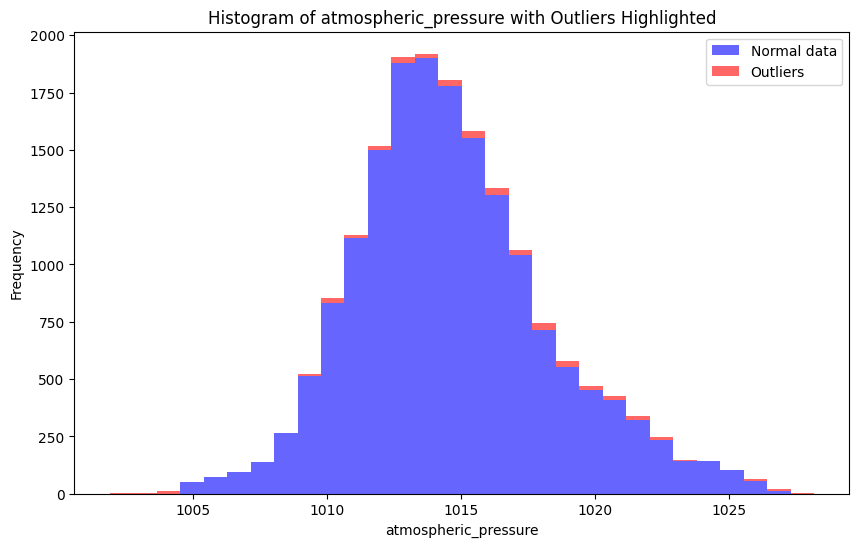

Plotting histogram for openmeteo_arona...


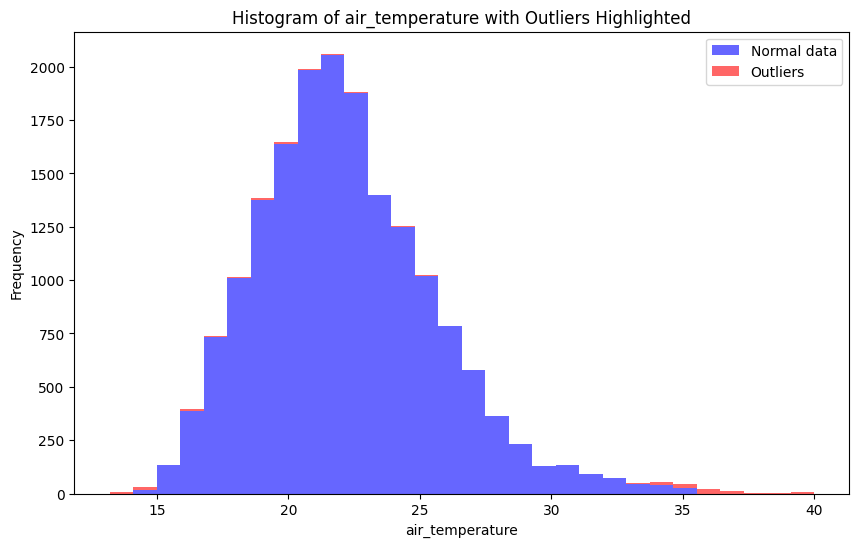

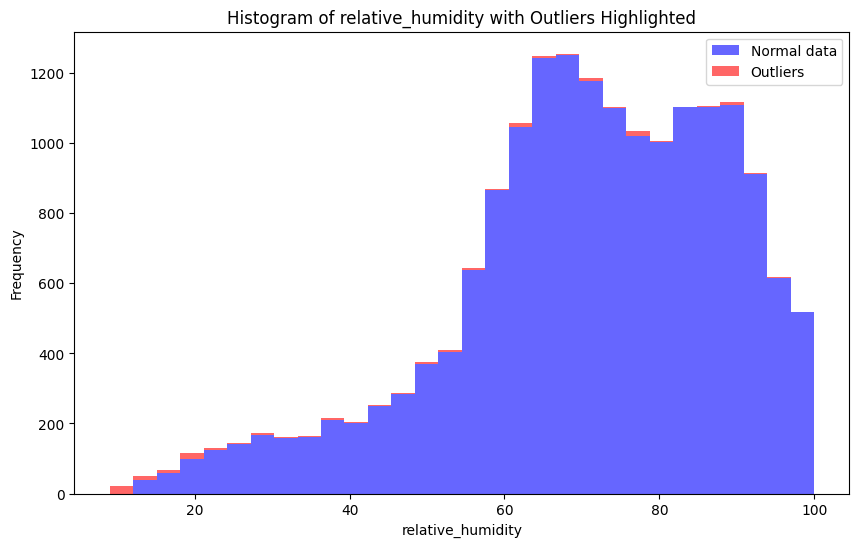

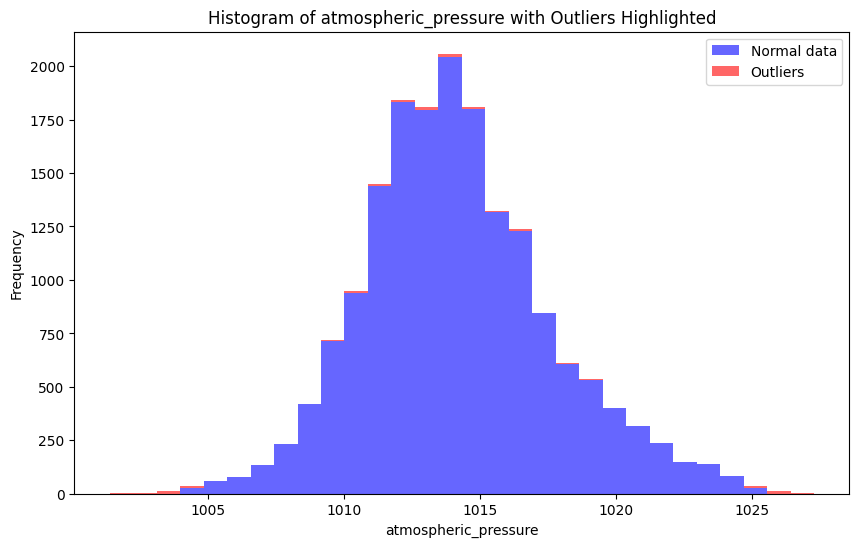

In [55]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [19]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_arona...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 4541.0477
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 5745.7675
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 6024.8542
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 24499.2393
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 24753.9266


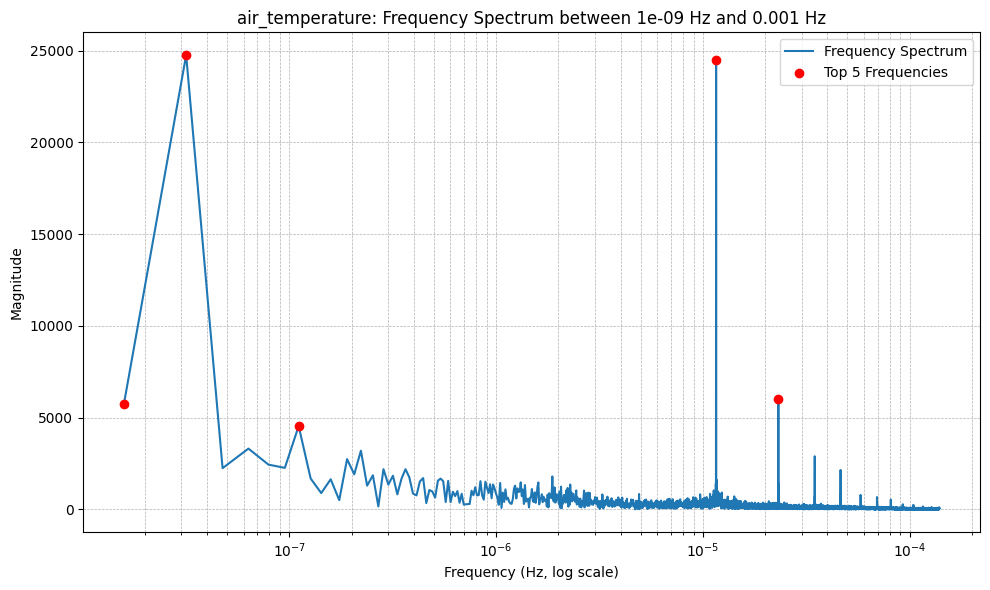

Top 5 frequencies with highest magnitude:
Frequency: 0.00000030 Hz, Period: 923.37 hours, Magnitude: 21676.8314
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 26158.1355
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 27516.5616
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 49369.7134
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 74220.8541


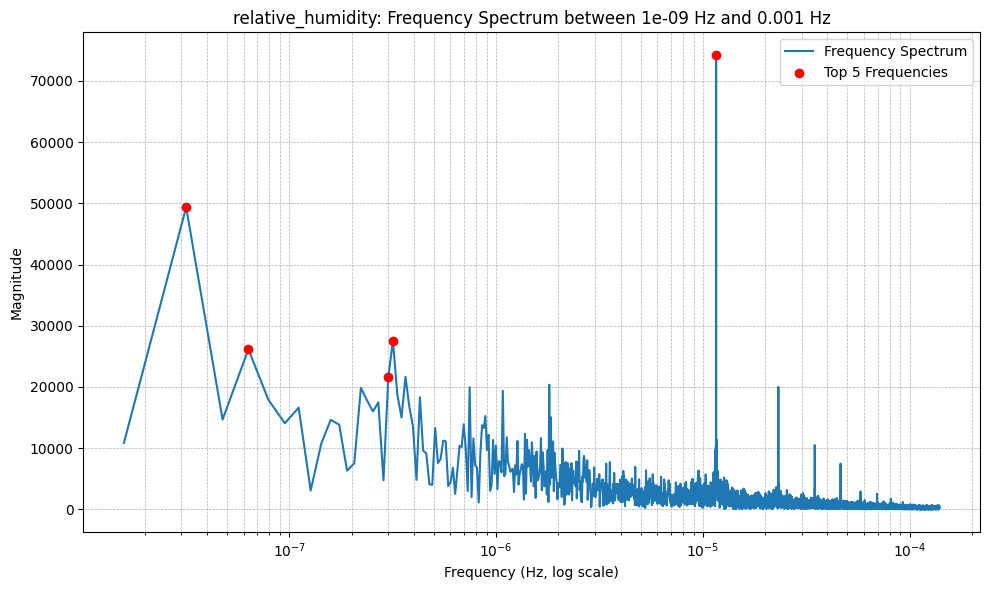

Top 5 frequencies with highest magnitude:
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 6932.6023
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7226.2143
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 7944.5646
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 12485.1913
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 24244.9109


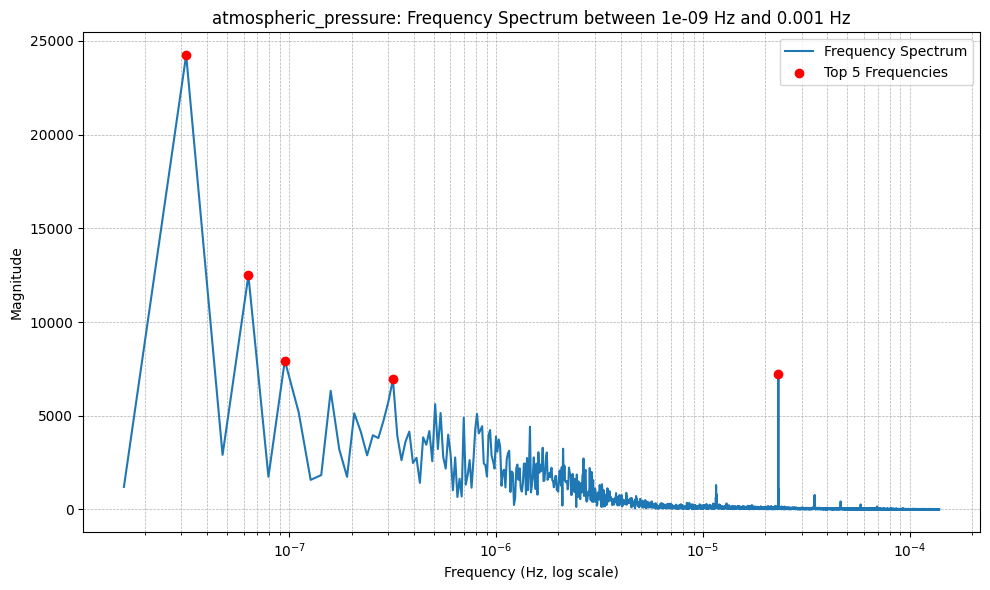

Plotting frequencies for openmeteo_arona...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 6217.1505
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 6341.6790
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 6834.1891
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 22443.7806
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 23659.1364


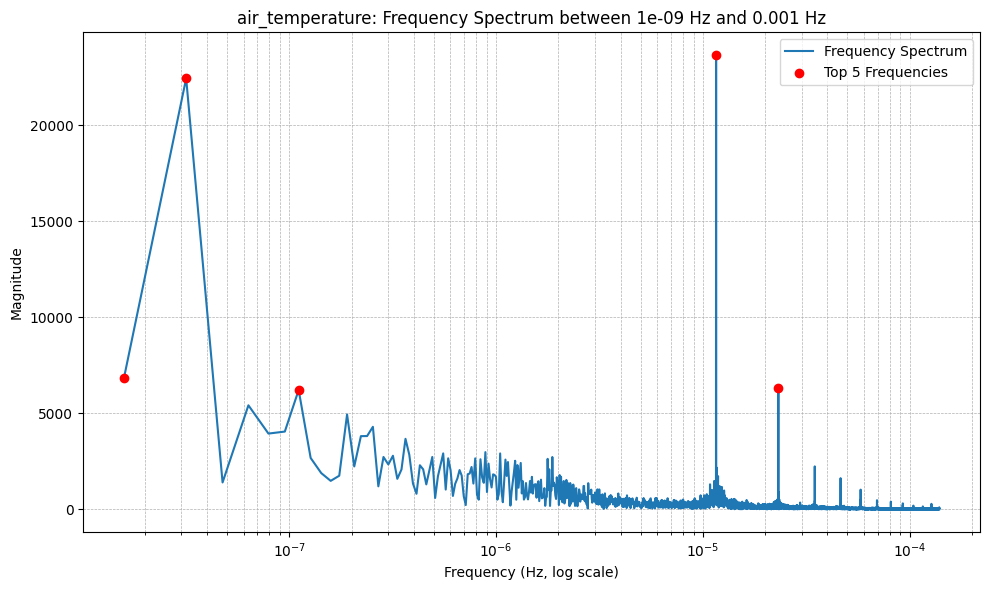

Top 5 frequencies with highest magnitude:
Frequency: 0.00000019 Hz, Period: 1462.00 hours, Magnitude: 30577.9859
Frequency: 0.00000008 Hz, Period: 3508.80 hours, Magnitude: 36007.4479
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 36289.1764
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 64872.5358
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 107387.6032


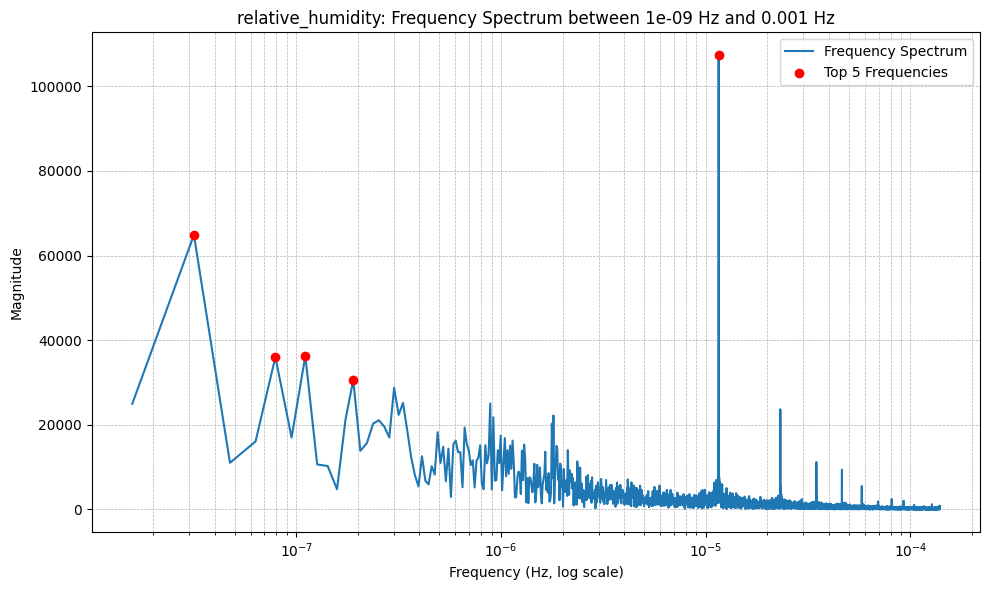

Top 5 frequencies with highest magnitude:
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 6824.4107
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7418.0416
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 7932.5248
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 11398.4291
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 21420.9823


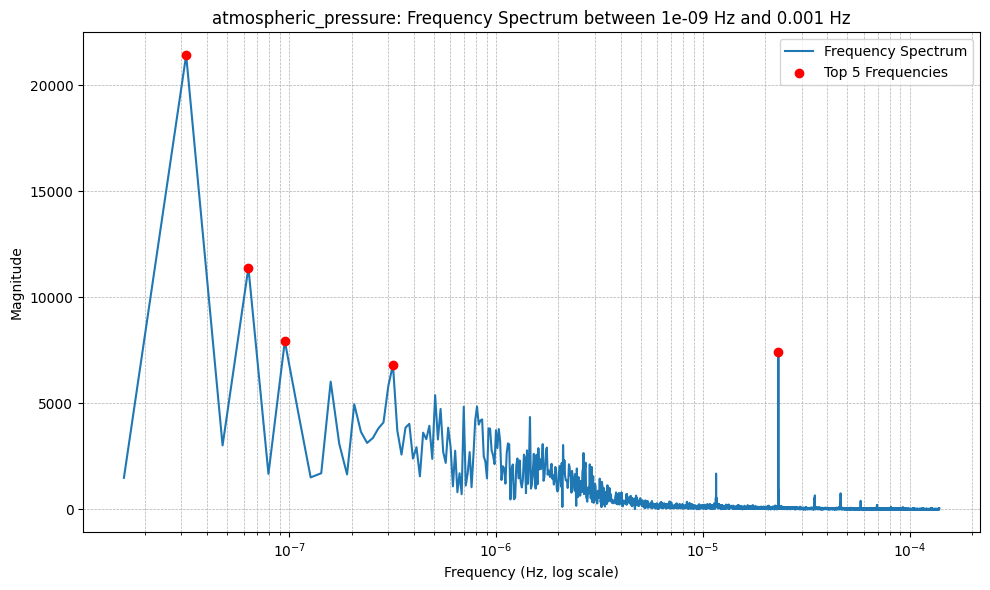

In [20]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [21]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_arona...


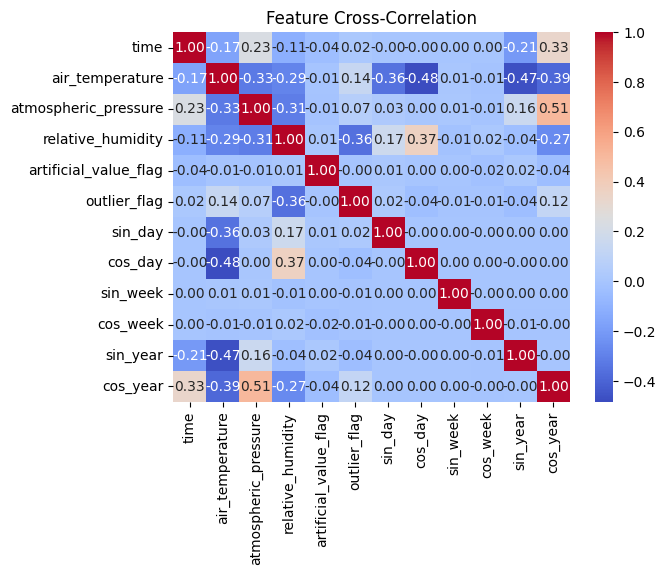

Plotting correlations for openmeteo_arona...


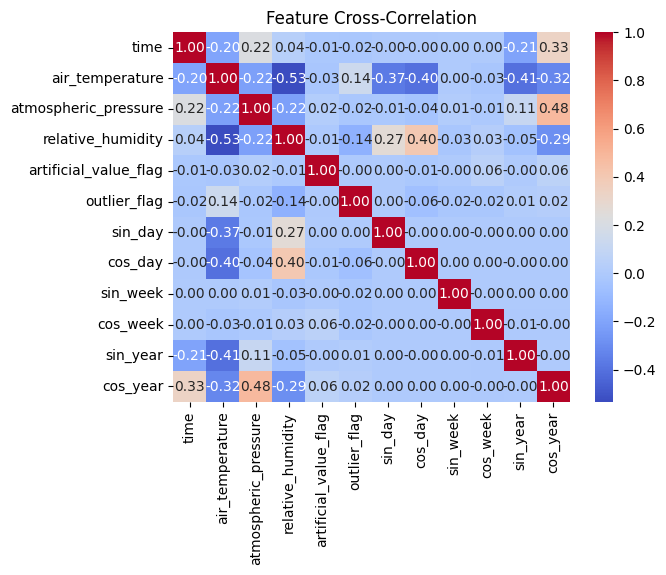

In [22]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [23]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [24]:
#for name, df in dataframes.items():
 # df.to_csv("processed_data/" + name + "_features.csv", index=False)